# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов.  
В нём можно быстро узнать рыночную стоимость своего автомобиля.  
В вашем распоряжении исторические данные:  
технические характеристики, комплектации и цены автомобилей.  
<b>Вам нужно построить модель для определения стоимости.</b>

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

In [3]:
data = pd.read_csv('autos.csv')
palette = ["#03071e", "#370617", "#6a040f", "#9d0208", "#d00000", "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08"]

### Новые названия столбцов

In [4]:
pd.DataFrame({
    '_____ Столбцы _____': data.columns[:4], 
    '_ ____________ _': data.columns[4:8], 
    '__ __________ __': data.columns[8:12],
    '___ ________ ___': data.columns[12:]
})

,_____ Столбцы _____,_ ____________ _,__ __________ __,___ ________ ___
0,DateCrawled,Gearbox,RegistrationMonth,DateCreated
1,Price,Power,FuelType,NumberOfPictures
2,VehicleType,Model,Brand,PostalCode
3,RegistrationYear,Kilometer,NotRepaired,LastSeen


In [5]:
columns = {
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'mileage_km',
    'RegistrationMonth': 'month_of_registration',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'NotRepaired': 'not_repaired',
    'DateCreated': 'date_of_creation',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen'
}
data = data.rename(columns=columns)
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage_km,month_of_registration,fuel_type,brand,not_repaired,date_of_creation,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- `price` — цена (евро) || **целевой признак**


- `date_crawled` — дата скачивания анкеты из базы
- `vehicle_type` — тип автомобильного кузова
- `registration_year` — год регистрации автомобиля
- `gearbox` — тип коробки передач
- `power` — мощность (л. с.)
- `model` — модель автомобиля
- `mileage_km` — пробег (км)
- `month_of_registration` — месяц регистрации автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `not_repaired` — была машина в ремонте или нет
- `date_of_creation` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля
- `postal_code` — почтовый индекс владельца анкеты (пользователя)
- `last_seen` — дата последней активности пользователя

In [6]:
data.describe()

,price,registration_year,power,mileage_km,month_of_registration,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   date_crawled           354369 non-null  object
 1   price                  354369 non-null  int64 
 2   vehicle_type           316879 non-null  object
 3   registration_year      354369 non-null  int64 
 4   gearbox                334536 non-null  object
 5   power                  354369 non-null  int64 
 6   model                  334664 non-null  object
 7   mileage_km             354369 non-null  int64 
 8   month_of_registration  354369 non-null  int64 
 9   fuel_type              321474 non-null  object
 10  brand                  354369 non-null  object
 11  not_repaired           283215 non-null  object
 12  date_of_creation       354369 non-null  object
 13  number_of_pictures     354369 non-null  int64 
 14  postal_code            354369 non-null  int64 
 15  

### Поиск дубликатов

In [8]:
def show_duplicates(data):
    duplicates = data.duplicated().sum()
    print(f'Количество дубликатов: {duplicates} ({duplicates / len(data):.3%})')

In [9]:
show_duplicates(data)

Количество дубликатов: 4 (0.001%)


In [10]:
processed_data = data.drop_duplicates().reset_index(drop=True)
show_duplicates(processed_data)

Количество дубликатов: 0 (0.000%)


### Анализ признаков

Признаки, которые не помогут в определении стоимости:
- `date_crawled`  
    Дата скачивания анкеты не может влиять на стоимость автомобиля.
- `month_of_registration`  
    Непонятно для чего в принципе может понадобится порядковый номер месяца регистрации автомобиля.
- `date_of_creation`  
    Точная дата публикации не понадобится, непонятно как обрабатывать этот признак для обучения.  
    Оставлю год публикации, так как стоимость может меняться год от года, как минимум под влиянием инфляции.
- `number_of_pictures`  
    Судя по описанию данных, столбец не заполнен, во всех строках стоят нули.  
    К тому же, количество фотографий автомобиля вряд ли влияет на его стоимость.
- `last_seen`  
    Дата последней активности пользователя не может влиять на стоимость автомобиля.

In [11]:
processed_data['date_crawled'] = processed_data['date_crawled'].astype('datetime64').dt.year
deleted_data = processed_data.query('date_crawled < registration_year')
print(f'Данных удалено: {len(deleted_data)} ({len(deleted_data)/len(processed_data):.2%})')
processed_data = processed_data.query('date_crawled >= registration_year')

Данных удалено: 14530 (4.10%)


In [12]:
columns_to_drop = ['postal_code']

In [13]:
processed_data['date_of_creation'] = processed_data['date_of_creation'].astype('datetime64')
processed_data['year_of_creation'] = processed_data['date_of_creation'].dt.year

In [14]:
columns_to_drop += [
    'date_crawled',
    'month_of_registration',
    'number_of_pictures',
    'last_seen',
    'date_of_creation',
]
processed_data = processed_data.drop(columns_to_drop, axis=1)

### Обработка пропусков

In [15]:
def show_nulls(data):
    nulls = data.isnull().sum()
    data_null = pd.DataFrame({
        'quantity': nulls,
        'percentage': round(nulls / len(data) * 100, 1)
    })
    data_null = data_null.query('percentage != 0').sort_values(by='percentage', ascending=False)
    data_null.columns = pd.MultiIndex.from_tuples(
        zip(['Количество пропусков в столбцах', 'Количество пропусков в столбцах'], data_null.columns)
    )
    if len(data_null) == 0:
        return 'Пропусков нет'
    return data_null

In [16]:
show_nulls(processed_data)

Количество пропусков в столбцах           
                                    quantity percentage
not_repaired                           64855       19.1
fuel_type                              27301        8.0
vehicle_type                           22980        6.8
gearbox                                17966        5.3
model                                  17658        5.2

#### Столбец `not_repaired`
Описание: была машина в ремонте или нет  

В этом столбце больше всего пропусков, заменить их с помощью других данных нельзя.  
Данных много, чтобы удалить без последствий.  
Присвою пропускам категорию `unknown`.

In [17]:
processed_data['not_repaired'] = processed_data['not_repaired'].fillna('unknown')
show_nulls(processed_data)

Количество пропусков в столбцах           
                                    quantity percentage
fuel_type                              27301        8.0
vehicle_type                           22980        6.8
gearbox                                17966        5.3
model                                  17658        5.2

#### Столбец `vehicle_type`

In [18]:
vehicles = processed_data['vehicle_type'].value_counts()
vehicles_df = pd.DataFrame({'Типы автомобилей': vehicles}).sort_values(by='Типы автомобилей', ascending=False)
vehicles_df

,Типы автомобилей
sedan,91453
small,79826
wagon,65161
bus,28773
convertible,20202
coupe,16158
suv,11995
other,3287


Помимо пропусков есть тип `other`, пропуски можно отнести к нему.

In [19]:
processed_data['vehicle_type'] = processed_data['vehicle_type'].fillna('other')
show_nulls(processed_data)

Количество пропусков в столбцах           
                                 quantity percentage
fuel_type                           27301        8.0
gearbox                             17966        5.3
model                               17658        5.2

#### Столбец `fuel_type`

In [20]:
fuels = processed_data['fuel_type'].value_counts()
fuel_df = pd.DataFrame({'Типы топлива': fuels}).sort_values(by='Типы топлива', ascending=False)
fuel_df

,Типы топлива
petrol,210015
gasoline,96308
lpg,5159
cng,542
hybrid,225
other,196
electric,89


Аналогично пропускам в `vehicle_type`, можно отнести пропуски в группу `other`.

In [21]:
processed_data['fuel_type'] = processed_data['fuel_type'].fillna('other')
show_nulls(processed_data)

Количество пропусков в столбцах           
                               quantity percentage
gearbox                           17966        5.3
model                             17658        5.2

#### Столбец `gearbox`

Заменить пропуски с помощью других данных нельзя.  
Данных много, чтобы удалить без последствий.  
Присвою пропускам категорию `unknown`.  

In [22]:
processed_data['gearbox'] = processed_data['gearbox'].fillna('unknown')
show_nulls(processed_data)

Количество пропусков в столбцах           
                             quantity percentage
model                           17658        5.2

#### Столбец `model`

Аналогично пропускам в `fuel_type` и `vehicle_type`, можно отнести пропуски в группу `other`.

In [23]:
processed_data['model'] = processed_data['model'].fillna('other')
show_nulls(processed_data)

'Пропусков нет'

### Обработка выбросов

In [24]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339835 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              339835 non-null  int64 
 1   vehicle_type       339835 non-null  object
 2   registration_year  339835 non-null  int64 
 3   gearbox            339835 non-null  object
 4   power              339835 non-null  int64 
 5   model              339835 non-null  object
 6   mileage_km         339835 non-null  int64 
 7   fuel_type          339835 non-null  object
 8   brand              339835 non-null  object
 9   not_repaired       339835 non-null  object
 10  year_of_creation   339835 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 31.1+ MB


#### Столбец `price`

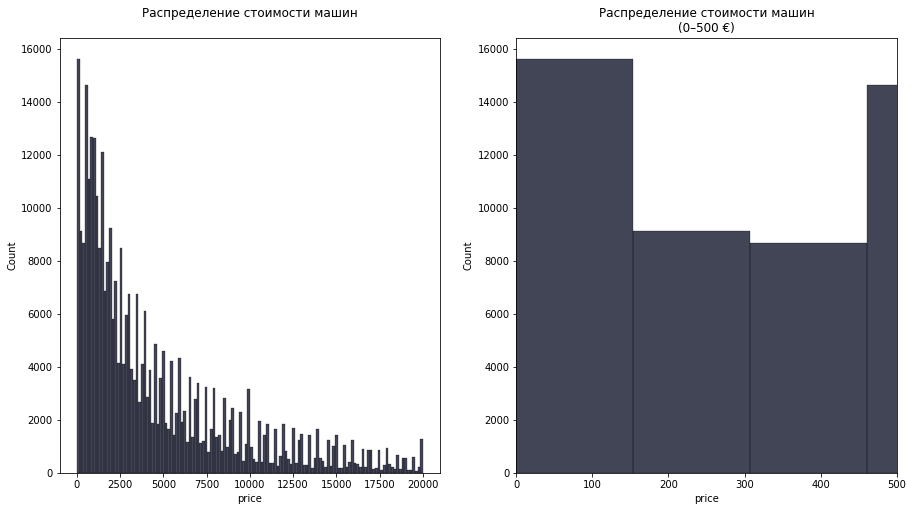

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.histplot(processed_data['price'], color='#03071E', ax=axes[0])
axes[0].set_title('Распределение стоимости машин\n')
sns.histplot(processed_data['price'], color='#03071E', ax=axes[1])
axes[1].set_title('Распределение стоимости машин\n(0–500 €)')
plt.xlim([0, 500])
plt.show()

In [26]:
low_price = processed_data.query('price == 0')['power'].count()
print(f'Количество автомобилей со стоимостью 0 €: {low_price} ({low_price / len(processed_data):.2%})')

Количество автомобилей со стоимостью 0 €: 10021 (2.95%)


Минимальная стоимость автомобиля на `auto.ru` на текущий момент — 15 тыс. руб. / ≈ 215 €.  
Можно удалить данные, у которых стоимость ниже 150 € (с учётом поправки на текущий курс евро).  

In [27]:
low_price_150 = processed_data.query('price < 150')['power'].count()
print(f'Количество автомобилей со стоимостью менее 150 €: {low_price_150} ({low_price_150 / len(processed_data):.2%})')

Количество автомобилей со стоимостью менее 150 €: 14066 (4.14%)


Количество довольно большое но попробую так.

In [28]:
processed_data = processed_data.query('price > 150')

#### Столбец `registration_year`

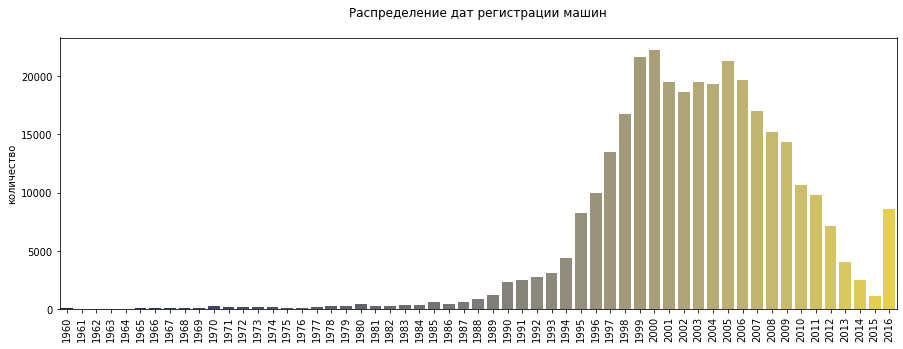

In [29]:
filt_data = processed_data.query('registration_year > 1959 & registration_year < 2023')
plt.figure(figsize=(15, 5))
pivot_years = filt_data.pivot_table(index='registration_year', values='power', aggfunc='count')
fig = sns.barplot(x=pivot_years.index, y='power', data=pivot_years, palette='cividis')
plt.title('Распределение дат регистрации машин\n')
plt.xlabel('')
plt.ylabel('количество')
plt.setp(fig.get_xticklabels(),rotation=90)
plt.show()

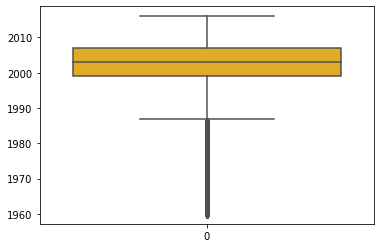

In [30]:
sns.boxplot(data=filt_data['registration_year'], color='#FFBA08')
plt.show()

In [31]:
rejected_year = processed_data.query('registration_year <= 1959 | registration_year >= 2023')['power'].count()
print(
    f'Количество отфильтрованных данных (до 1960 и после 2022 года)\n'
    f'{rejected_year} ({rejected_year / len(data):.2%})'
)

Количество отфильтрованных данных (до 1960 и после 2022 года)
293 (0.08%)


Непонятно от какой даты можно считать валидными дату регистрации автомобиля.  
Предварительно возьму рамки 1960–2022 годы.  

In [32]:
processed_data = filt_data

#### Столбец `power`

In [33]:
processed_data['power'].describe()

count    323900.000000
mean        112.961902
std         184.654344
min           0.000000
25%          74.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Мощность серийных автомобилей находится в диапазоне ≈ 4-1600 л.с., судя по статьям в интернете.<br>

In [34]:
filt_data = processed_data.query('power > 3 & power <= 1600')
data_loss = len(processed_data) - len(filt_data)
print(f'Потеря данных при фильтрации: {data_loss} ({data_loss / len(processed_data):.2%})')

Потеря данных при фильтрации: 30537 (9.43%)


У 10% данных указанная мощность менее или равна 3 л.с., это большое количество, убирать их вредно.  
Несмотря на то, что автомобилей указанной мощности найти не удалось.  

In [35]:
filt_data = processed_data.query('power <= 1600')
data_loss = len(processed_data) - len(filt_data)
print(f'Потеря данных при фильтрации: {data_loss} ({data_loss / len(processed_data):.2%})')

Потеря данных при фильтрации: 147 (0.05%)


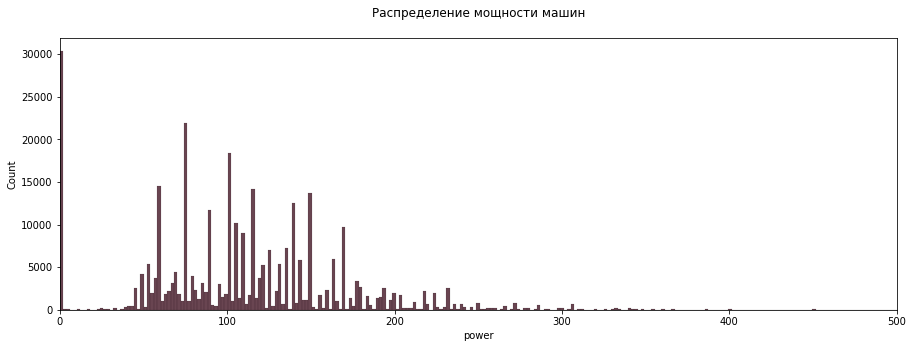

In [36]:
plt.figure(figsize=(15, 5))
sns.histplot(filt_data['power'], color='#370617')
plt.title('Распределение мощности машин\n')
plt.xlim([0, 500])
plt.show()

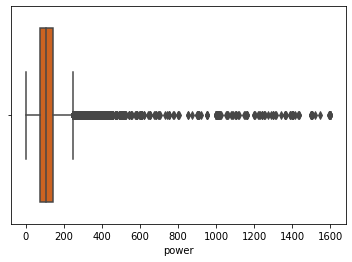

In [37]:
sns.boxplot(x=filt_data['power'], color='#E85D04')
plt.show()

In [38]:
processed_data = filt_data.copy()

#### Столбец `mileage_km`

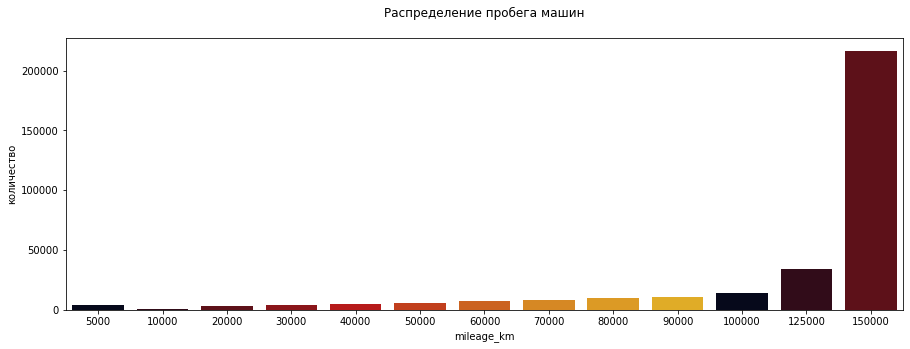

In [39]:
plt.figure(figsize=(15, 5))
pivot_mileage = processed_data.pivot_table(index='mileage_km', values='price', aggfunc='count')
fig = sns.barplot(x=pivot_mileage.index, y='price', data=pivot_mileage, palette=palette)
plt.ylabel('количество')
plt.title('Распределение пробега машин\n')
plt.show()

In [40]:
processed_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage_km,fuel_type,brand,not_repaired,year_of_creation
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown,2016
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016


Пробег разбит на категории несмотря на то, что категории заданы числами.  
Бо́льшая часть в категории 150 тыс. км.  
Возможно, что в эту категорию попадают автомобили с пробегом 150 000+ км.  

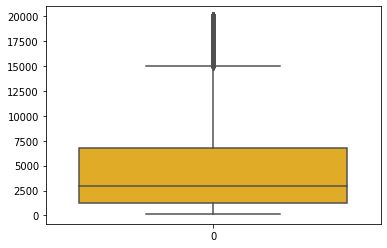

In [41]:
sns.boxplot(data=processed_data['price'], color='#FFBA08')
plt.show()

### Обработка категориальных признаков

Категориальные признаки,  
которые можно обработать методом `One-Hot Encoding` из-за их малочисленности:
- `vehicle_type`
- `gearbox`
- `fuel_type`
- `not_repaired`

Категориальные признаки,  
которые можно обработать методом `Ordinal Encoding` из-за их многочисленности:
- `model`
- `brand`

Категориальные признаки, которые не нужно обрабатывать:  
- `postal_code`
- `year_of_creation`

In [42]:
def ohe(data, column):
    data_ohe = pd.get_dummies(data[column], drop_first=True, prefix=column)
    data = data.drop(column, axis=1).join(data_ohe)
    return data

In [43]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323753 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              323753 non-null  int64 
 1   vehicle_type       323753 non-null  object
 2   registration_year  323753 non-null  int64 
 3   gearbox            323753 non-null  object
 4   power              323753 non-null  int64 
 5   model              323753 non-null  object
 6   mileage_km         323753 non-null  int64 
 7   fuel_type          323753 non-null  object
 8   brand              323753 non-null  object
 9   not_repaired       323753 non-null  object
 10  year_of_creation   323753 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 37.7+ MB


#### Столбец `vehicle_type`

In [44]:
vehicles_df

,Типы автомобилей
sedan,91453
small,79826
wagon,65161
bus,28773
convertible,20202
coupe,16158
suv,11995
other,3287


In [45]:
processed_data = ohe(processed_data, 'vehicle_type')

In [46]:
processed_data.loc[:, 'year_of_creation':].head()

,year_of_creation,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon
0,2016,0,0,1,0,0,0,0
1,2016,0,1,0,0,0,0,0
2,2016,0,0,0,0,0,1,0
3,2016,0,0,0,0,1,0,0
4,2016,0,0,0,0,1,0,0


#### Столбец `gearbox`

In [47]:
gearboxes = processed_data['gearbox'].value_counts()
gearbox_df = pd.DataFrame(
    {'Типы коробки переключения передач': gearboxes}
).sort_values(
    by='Типы коробки переключения передач', ascending=False
)
gearbox_df

,Типы коробки переключения передач
manual,247213
auto,62620
unknown,13920


In [48]:
processed_data = ohe(processed_data, 'gearbox')

In [49]:
processed_data.loc[:, 'vehicle_type_wagon':].head()

,vehicle_type_wagon,gearbox_manual,gearbox_unknown
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0


#### Столбец `fuel_type`

In [50]:
fuel_df

,Типы топлива
petrol,210015
gasoline,96308
lpg,5159
cng,542
hybrid,225
other,196
electric,89


In [51]:
processed_data = ohe(processed_data, 'fuel_type')

In [52]:
processed_data.loc[:, 'gearbox_unknown':].head()

,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0


#### Столбец `not_repaired`

In [53]:
processed_data['not_repaired'].head()

0    unknown
1        yes
2    unknown
3         no
4         no
Name: not_repaired, dtype: object

In [54]:
processed_data = ohe(processed_data, 'not_repaired')

In [55]:
processed_data.loc[:, 'fuel_type_petrol':].head()

,fuel_type_petrol,not_repaired_unknown,not_repaired_yes
0,1,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,0,0,0


#### Столбцы `model` и `brand`

In [56]:
encoder = OrdinalEncoder()

processed_data = processed_data.reset_index()
data_ordinal = pd.DataFrame(encoder.fit_transform(processed_data), columns=processed_data.columns)
processed_data[['model', 'brand']] = data_ordinal[['model', 'brand']]
processed_data[['model', 'brand']] = processed_data[['model', 'brand']].astype(int)

In [57]:
processed_data[['model', 'brand']].head()

,model,brand
0,116,38
1,166,1
2,117,14
3,116,38
4,101,31


### Подготовка выборок

In [58]:
target = processed_data['price']
features = processed_data.drop('price', axis=1)
#features_train, features_test, target_train, target_test = train_test_split(
#    features, target, test_size=0.25, random_state=12345
#)

In [59]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.50, random_state=12345
)
print(
    f'Разделение выборки в следующих пропорциях:\n'
    f'{(len(features_train)/len(processed_data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(processed_data)):.0%} — тестовая;\n'
    f'{(len(features_valid)/len(processed_data)):.0%} — валидационная.'
)

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


In [60]:
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)
features_valid = scaler.fit_transform(features_valid)

***
### Вывод 

- Поправил название столбцов
- Удалил столбцы, которые не могут повлиять на стоимость автомобиля  
    (`date_crawled`, `month_of_registration`, `number_of_pictures`, `last_seen`)
- Столбец `date_of_creation` преобразовал в год публикации
- Обработал пропуски
- Обработал выбросы
- Преобразовал категориальные признаки  
    - Методом *One-Hot Encoding*:  
    `vehicle_type`, `gearbox`, `fuel_type`, `not_repaired`  
    - Методом *Ordinal Encoding*:  
    `model`, `brand`
- Подготовил выборки<br><br>
***

## Обучение и анализ моделей

### Модель `Linear Regression`

In [61]:
model = LinearRegression()

In [62]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [63]:
linear_fit_time = result.stdout
linear_fit_time_short = linear_fit_time.split(' per loop ')[0]

In [64]:
predictions = model.predict(features_valid)

In [65]:
%%capture result
%%timeit
model.predict(features_valid)

In [66]:
linear_prediction_time = result.stdout
linear_prediction_time_short = linear_prediction_time.split(' per loop ')[0]

In [67]:
linear_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [68]:
models_compares = {
    'LinearRegression': {
        'fit_time': linear_fit_time_short,
        'prediction_time': linear_prediction_time_short,
        'rmse': linear_rmse,
    },
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,357 ms +- 39.3 ms,14.1 ms +- 1 ms,2995.744553


### Модель `Случайный лес`

In [69]:
best_rmse = 10000
best_depth = 0
best_estim = 0
for estim in range(19, 20, 3):
    for depth in range(23, 24, 3):
        model = RandomForestRegressor(random_state=1234, n_estimators=estim, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_estim = estim
print(
    f'Количество деревьев: {best_estim}\n'
    f'Глубина: {best_depth}\n'
    f'RMSE: {best_rmse}'
)

Количество деревьев: 19
Глубина: 23
RMSE: 1677.2070654762488


In [70]:
model = RandomForestRegressor(random_state=1234, n_estimators=best_estim, max_depth=best_depth)

In [71]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [72]:
forest_fit_time = result.stdout
forest_fit_time_short = forest_fit_time.split(' per loop ')[0]

In [73]:
predictions = model.predict(features_valid)

In [74]:
%%capture result
%%timeit
model.predict(features_valid)

In [75]:
forest_prediction_time = result.stdout
forest_prediction_time_short = forest_prediction_time.split(' per loop ')[0]

In [76]:
forest_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [77]:
models_compares['RandomForestRegressor'] = {
        'fit_time': forest_fit_time_short,
        'prediction_time': forest_prediction_time_short,
        'rmse': forest_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,357 ms +- 39.3 ms,14.1 ms +- 1 ms,2995.744553
RandomForestRegressor,15.7 s +- 210 ms,439 ms +- 4.69 ms,1677.207065


### Модель `CatBoostRegressor`

In [78]:
model = CatBoostRegressor(random_state=1234, learning_rate=0.5, verbose=False)

In [79]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [80]:
catboost_fit_time = result.stdout
catboost_fit_time_short = catboost_fit_time.split(' per loop ')[0]

In [81]:
predictions = model.predict(features_valid)

In [82]:
%%capture result
%%timeit
model.predict(features_valid)

In [83]:
catboost_prediction_time = result.stdout
catboost_prediction_time_short = catboost_prediction_time.split(' per loop ')[0]

In [84]:
catboost_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [85]:
models_compares['CatBoostRegressor'] = {
        'fit_time': catboost_fit_time_short,
        'prediction_time': catboost_prediction_time_short,
        'rmse': catboost_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,357 ms +- 39.3 ms,14.1 ms +- 1 ms,2995.744553
RandomForestRegressor,15.7 s +- 210 ms,439 ms +- 4.69 ms,1677.207065
CatBoostRegressor,26 s +- 344 ms,64.9 ms +- 2.25 ms,1593.626303


### Модель `LGBMRegressor`

In [86]:
model = LGBMRegressor(random_state=1234, learning_rate=0.5, num_leaves=100)

In [87]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [88]:
lgbm_fit_time = result.stdout
lgbm_fit_time_short = lgbm_fit_time.split(' per loop ')[0]

In [89]:
predictions = model.predict(features_valid)

In [90]:
%%capture result
%%timeit
model.predict(features_valid)

In [91]:
lgbm_prediction_time = result.stdout
lgbm_prediction_time_short = lgbm_prediction_time.split(' per loop ')[0]

In [92]:
lgbm_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [93]:
models_compares['LGBMRegressor'] = {
        'fit_time': '4min 2s +- 7min 1s',
        'prediction_time': lgbm_prediction_time_short,
        'rmse': lgbm_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,prediction_time,rmse
LinearRegression,357 ms +- 39.3 ms,14.1 ms +- 1 ms,2995.744553
RandomForestRegressor,15.7 s +- 210 ms,439 ms +- 4.69 ms,1677.207065
CatBoostRegressor,26 s +- 344 ms,64.9 ms +- 2.25 ms,1593.626303
LGBMRegressor,4min 2s +- 7min 1s,415 ms +- 31.9 ms,1648.020385


### Финальное тестирование `RandomForestRegressor`

In [94]:
model = RandomForestRegressor(random_state=1234, n_estimators=best_estim, max_depth=best_depth)

In [95]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [96]:
forest_fit_time = result.stdout
forest_fit_time_short = forest_fit_time.split(' per loop ')[0]

In [97]:
predictions = model.predict(features_test)

In [98]:
%%capture result
%%timeit
model.predict(features_test)

In [99]:
forest_prediction_time = result.stdout
forest_prediction_time_short = forest_prediction_time.split(' per loop ')[0]

In [100]:
forest_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [101]:
models_compares['RandomForestRegressor (test)'] = {
        'fit_time': forest_fit_time_short,
        'prediction_time': forest_prediction_time_short,
        'rmse': forest_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,357 ms +- 39.3 ms,14.1 ms +- 1 ms,2995.744553
RandomForestRegressor,15.7 s +- 210 ms,439 ms +- 4.69 ms,1677.207065
CatBoostRegressor,26 s +- 344 ms,64.9 ms +- 2.25 ms,1593.626303
LGBMRegressor,4min 2s +- 7min 1s,415 ms +- 31.9 ms,1648.020385
RandomForestRegressor (test),15.5 s +- 162 ms,436 ms +- 5.61 ms,1821.464273


***
## Общий вывод

- Худшая по времени обучения модель — `LGBMRegressor` — 4 ± 7 минут.  
    По данной модели был комментарий:  
    The slowest run took 20.26 times longer than the fastest.  
    This could mean that an intermediate result is being cached.  
- `RandomForestRegressor` и `CatBoostRegressor` примерно похожи по времени и по RMSE.  
    Тем не менее `RandomForestRegressor` отрабатывает быстрее примерно на 10 секунд  
    при незначительной потери точности предсказаний.
- При условии, что для `RandomForestRegressor` можно подобрать даже лучшие параметры, следует рекомендовать эту модель.<br><br>

***